In [ ]:
!unzip /content/stock_data_natalie.zip

Archive:  /content/stock_data_natalie.zip
   creating: stock_data/
  inflating: stock_data/AAPL.png     
  inflating: stock_data/AAPL_pred.csv  
  inflating: stock_data/AMZN.png     
  inflating: stock_data/AMZN_pred.csv  
  inflating: stock_data/DIS.png      
  inflating: stock_data/DIS_pred.csv  
  inflating: stock_data/GOOG.png     
  inflating: stock_data/GOOG_pred.csv  
  inflating: stock_data/MSFT.png     
  inflating: stock_data/MSFT_pred.csv  
  inflating: stock_data/NFLX.png     
  inflating: stock_data/NFLX_pred.csv  
  inflating: stock_data/PYPL.png     
  inflating: stock_data/PYPL_pred.csv  
  inflating: stock_data/SHOP.png     
  inflating: stock_data/SHOP_pred.csv  
  inflating: stock_data/TSLA.png     
  inflating: stock_data/TSLA_pred.csv  


In [ ]:
!pip install --upgrade pandas-datareader
!pip install PyPortfolioOpt

     |████████████████████████████████| 109 kB 17.6 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
     |████████████████████████████████| 61 kB 4.5 MB/s 
     |████████████████████████████████| 2.8 MB 33.2 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
import os
import pandas as pd

data_dir = 'stock_data'
stock_pred = {}
for f in os.listdir(data_dir):
  if f[-3:] == 'csv':
    stock_pred[f.split('_')[0]] = pd.read_csv(os.path.join(data_dir, f), parse_dates = ['Dates'], index_col=0)

In [ ]:
import pandas_datareader as pdr

start = '2020-9-30'
end = '2021-9-30'

tickers = stock_pred.keys()
stock_actual = {}
for ticker in tickers:
  stock_actual[ticker] = pdr.data.DataReader(ticker, start=start, end=end, data_source='yahoo')

# s&p 500 as market price proxy
market_prices = pdr.data.DataReader('SPY', start=start, end=end, data_source='yahoo')
test_size = 30

In [ ]:
tickers

dict_keys(['DIS', 'PYPL', 'SHOP', 'NFLX', 'GOOG', 'TSLA', 'AAPL', 'MSFT', 'AMZN'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
sns.set()

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

In [ ]:
stock_accepted = {}
for ticker, results in stock_pred.items():
  accepted_results = []
  for r in results.values.T:
      if (np.array(r[-test_size:]) < np.min(stock_actual[ticker]['Close'])).sum() == 0 and \
      (np.array(r[-test_size:]) > np.max(stock_actual[ticker]['Close']) * 2).sum() == 0:
          accepted_results.append(r)
  len(accepted_results)
  stock_accepted[ticker] = accepted_results

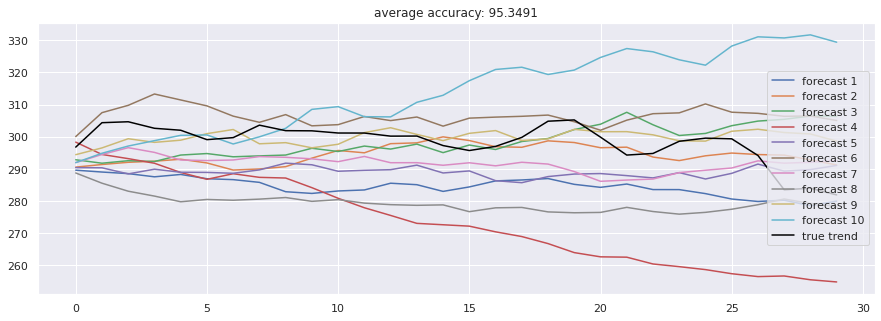

In [ ]:
tick = 'MSFT'
df = stock_actual[tick]
results = stock_accepted[tick]

accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

In [ ]:
# df.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:]

In [ ]:
df.sum(axis = 0)/len(df)

High         2.500505e+02
Low          2.458463e+02
Open         2.478956e+02
Close        2.480613e+02
Volume       2.662789e+07
Adj Close    2.461005e+02
dtype: float64

In [ ]:
stock_best = {}
# Select highest accuracy prediction
for ticker, results in stock_pred.items():
  df = stock_actual[ticker]
  accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results.values.T]
  stock_best[ticker] = results[str(np.argmax(accuracies))]

In [ ]:
from pypfopt.risk_models import CovarianceShrinkage

In [ ]:
portfolio = pd.concat([v['Close'].iloc[1:] for v in stock_actual.values()], 1, keys = stock_actual.keys())
portfolio_returns = portfolio.pct_change() #daily pct change of stocks

best_preds = pd.concat(stock_best.values(), 1, keys = stock_best.keys())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  after removing the cwd from sys.path.


In [ ]:
best_preds.head()

,DIS,PYPL,SHOP,NFLX,GOOG,TSLA,AAPL,MSFT,AMZN
Dates,,,,,,,,,
2021-10-01,175.280348,268.639511,1508.568018,522.466404,2737.346758,694.780079,146.864667,294.420332,3177.083147
2021-10-02,173.570309,272.517025,1523.284238,522.400873,2759.876408,697.049017,145.656286,296.522048,3147.737885
2021-10-03,174.077121,271.635578,1512.353233,524.164165,2756.233310,692.313127,145.149721,299.376099,3105.860283
2021-10-04,174.211406,270.052819,1524.922367,525.848248,2782.727156,696.614441,145.790069,298.245574,3073.599879
2021-10-05,175.095298,272.171892,1528.251293,520.032778,2802.406470,698.635344,146.049916,298.923123,3013.224156


In [ ]:
cs_actual = CovarianceShrinkage(portfolio)
e_cov = cs_actual.ledoit_wolf()
print("Efficient Covariance Matrix Actual\n", e_cov, "\n")

cs_LSTM = CovarianceShrinkage(best_preds)
e_cov_LSTM = cs_LSTM.ledoit_wolf()
print("Efficient Covariance Matrix Bi-LSTM\n", e_cov_LSTM, "\n")

Efficient Covariance Matrix Actual
            DIS      PYPL      SHOP      NFLX      GOOG      TSLA      AAPL  \
DIS   0.098368  0.007075 -0.009484  0.002084  0.018161  0.007908  0.007926   
PYPL  0.007075  0.140180  0.108972  0.053125  0.041016  0.087174  0.056679   
SHOP -0.009484  0.108972  0.234085  0.070723  0.034425  0.092610  0.054468   
NFLX  0.002084  0.053125  0.070723  0.121318  0.029310  0.054218  0.042253   
GOOG  0.018161  0.041016  0.034425  0.029310  0.065086  0.036285  0.035956   
TSLA  0.007908  0.087174  0.092610  0.054218  0.036285  0.283543  0.058656   
AAPL  0.007926  0.056679  0.054468  0.042253  0.035956  0.058656  0.080834   
MSFT  0.010424  0.047580  0.044796  0.034557  0.036020  0.041194  0.040859   
AMZN  0.005210  0.057894  0.063564  0.047577  0.034836  0.051857  0.046467   

          MSFT      AMZN  
DIS   0.010424  0.005210  
PYPL  0.047580  0.057894  
SHOP  0.044796  0.063564  
NFLX  0.034557  0.047577  
GOOG  0.036020  0.034836  
TSLA  0.041194  0.051

**The Critical Line Algorithm**

This is a robust alternative to the quadratic solver used to find mean-variance optimal portfolios, that is especially advantageous when we apply linear inequalities. Unlike generic convex optimization routines, the CLA is specially designed for portfolio optimization. It is guaranteed to converge after a certain number of iterations, and can efficiently derive the entire efficient frontier.



OrderedDict([('DIS', 0.27903298173122887), ('PYPL', 0.0), ('SHOP', 0.005457147531009958), ('NFLX', 0.08427514813210976), ('GOOG', 0.14151131908417056), ('TSLA', 0.0), ('AAPL', 0.0633661586039792), ('MSFT', 0.2981338500936123), ('AMZN', 0.1282233948238891)])
OrderedDict([('DIS', 0.2790329817312289), ('PYPL', 0.0), ('SHOP', 0.005457147531009929), ('NFLX', 0.08427514813210983), ('GOOG', 0.1415113190841702), ('TSLA', 0.0), ('AAPL', 0.06336615860397929), ('MSFT', 0.2981338500936129), ('AMZN', 0.12822339482388898)])


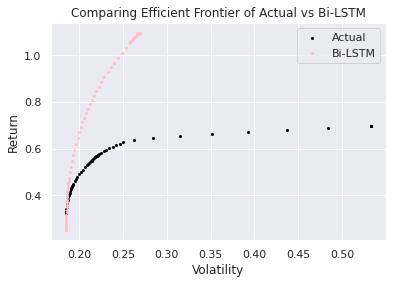

In [ ]:
from pypfopt import CLA

# Initialize the Crtical Line Algorithm object
efficient_portfolio_actual = CLA(portfolio_returns.mean().dropna()*252, e_cov)
efficient_portfolio_LSTM = CLA(best_preds.pct_change().mean().dropna()*252, e_cov)
# Find the minimum volatility portfolio weights and display them
print(efficient_portfolio_actual.min_volatility())
print(efficient_portfolio_LSTM.min_volatility())
# Compute the efficient frontier
(ret, vol, weights) = efficient_portfolio_actual.efficient_frontier()
(ret_AR, vol_AR, weights_AR) = efficient_portfolio_LSTM.efficient_frontier()

# Add the frontier to the plot showing the 'before' and 'after' frontiers
plt.scatter(vol, ret, s = 4, c = 'black', label = 'Actual')
plt.scatter(vol_AR, ret_AR, s = 4, c = 'pink', label = 'Bi-LSTM')
plt.legend()
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Comparing Efficient Frontier of Actual vs Bi-LSTM')
plt.show()

In [ ]:
best_preds

,DIS,PYPL,SHOP,NFLX,GOOG,TSLA,AAPL,MSFT,AMZN
Dates,,,,,,,,,
2021-10-01,175.280348,268.639511,1508.568018,522.466404,2737.346758,694.780079,146.864667,294.420332,3177.083147
2021-10-02,173.570309,272.517025,1523.284238,522.400873,2759.876408,697.049017,145.656286,296.522048,3147.737885
2021-10-03,174.077121,271.635578,1512.353233,524.164165,2756.233310,692.313127,145.149721,299.376099,3105.860283
2021-10-04,174.211406,270.052819,1524.922367,525.848248,2782.727156,696.614441,145.790069,298.245574,3073.599879
2021-10-05,175.095298,272.171892,1528.251293,520.032778,2802.406470,698.635344,146.049916,298.923123,3013.224156
2021-10-06,176.566474,274.231863,1499.887054,514.814424,2822.471465,707.294624,145.660196,300.956659,3022.059733
2021-10-07,176.900259,275.165642,1501.236276,509.176304,2782.026637,706.547398,145.399898,302.240303,2948.692022
2021-10-08,178.492027,276.308764,1485.058545,505.243071,2773.980094,714.409597,146.098006,297.802437,3142.923895
2021-10-09,180.542420,277.384510,1490.740475,503.967407,2791.986978,715.056424,145.508197,298.152582,3202.438254


***Reason we are using min_vol portfolios instead of max_sharpe:***

There is a large body of research that suggests that minimum variance portfolios (ef.min_volatility()) consistently outperform maximum Sharpe ratio portfolios out-of-sample (even when measured by Sharpe ratio), because of the difficulty of forecasting expected returns.

**Black-Litterman Allocation**

https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html

***Why use BL model?***
The Black-Litterman (BL) model takes a Bayesian approach to asset allocation. Specifically, it combines a prior estimate of returns (for example, the market-implied returns) with views on certain assets, to produce a posterior estimate of expected returns. The advantages of this are:

You can provide views on only a subset of assets and BL will meaningfully propagate it, taking into account the covariance with other assets.

***views in this case => predicted result by bi-LSTM model***

You can provide confidence in your views.
Using Black-Litterman posterior returns results in much more stable portfolios than using mean-historical return.


In [ ]:
from pypfopt import black_litterman, plotting, objective_functions
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

mcaps = {tick:int(pdr.data.get_quote_yahoo(tick)['marketCap']) for tick in stock_actual.keys()}
# 30 day return predicted using bi-lstm
viewdict = ((best_preds.iloc[-1]- best_preds.iloc[0])/best_preds.iloc[0]).round(3).to_dict()
# 30 day predicted return using random forest regressor
viewdict_rf = {'PYPL': 0.063, 'SHOP': 0.088, 'TSLA': 0.001, 'GOOG': 0.074, 'DIS': -0.005, 'AAPL': 0.026, 'MSFT': 0.042, 'NFLX': 0.016, 'AMZN': 0.094}

In [ ]:
portfolio = pd.concat([v['Close'].iloc[1:] for v in stock_actual.values()], 1, keys = stock_actual.keys()).iloc[:-test_size]
portfolio_returns = portfolio.pct_change() #daily pct change of stocks
cs_actual = CovarianceShrinkage(portfolio)
e_cov = cs_actual.ledoit_wolf()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
market_prices['Close'].head(3) #using s&p 500 as proxy for market prices

Date
2020-09-30    334.890015
2020-10-01    337.040009
2020-10-02    333.839996
Name: Close, dtype: float64

 BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

In [ ]:
# 2.89% 10 year treasury bond yield is risk free rate
delta = black_litterman.market_implied_risk_aversion(market_prices['Close'].iloc[:-test_size], risk_free_rate=0.0289)
prior = black_litterman.market_implied_prior_returns(mcaps, delta, e_cov)

In [ ]:
prior

DIS     0.176740
PYPL    0.886680
SHOP    0.881388
NFLX    0.666741
GOOG    0.644966
TSLA    1.186790
AAPL    0.867617
MSFT    0.675117
AMZN    0.750737
dtype: float64

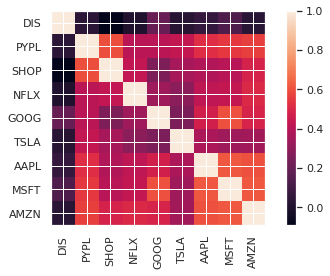

In [ ]:
plotting.plot_covariance(e_cov, plot_correlation=True);

In [ ]:
viewdict

{'AAPL': -0.074,
 'AMZN': 0.13,
 'DIS': 0.006,
 'GOOG': 0.037,
 'MSFT': 0.014,
 'NFLX': 0.084,
 'PYPL': 0.124,
 'SHOP': -0.153,
 'TSLA': 0.025}

There is nothing stopping you from using any prior you see fit (but it must have the same dimensionality as the universe). If you think that the mean historical returns are a good prior, you could go with that. But a significant body of research shows that mean historical returns are a completely uninformative prior.

***Using mcaps as prior***

In [ ]:
bl = BlackLittermanModel(e_cov, pi=prior, absolute_views=viewdict)
# Posterior estimate of returns
ret_bl = bl.bl_returns()
S_bl = bl.bl_cov()

bl_rf = BlackLittermanModel(e_cov, pi=prior, absolute_views=viewdict_rf)
# Posterior estimate of returns
ret_bl_rf = bl_rf.bl_returns()
S_bl_rf = bl_rf.bl_cov()

In [ ]:
bl.bl_weights(delta)
bl_weights = bl.clean_weights()

bl_rf.bl_weights(delta)
bl_rf_weights = bl_rf.clean_weights()

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl, verbose = False)
ef.add_objective(objective_functions.L2_reg)

ef_rf = EfficientFrontier(ret_bl_rf, S_bl_rf, verbose = False)
ef_rf.add_objective(objective_functions.L2_reg)

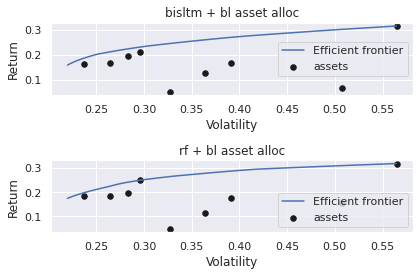

In [ ]:
fig, ax = plt.subplots(2)
ax[0].set_title('bisltm + bl asset alloc')
ax[1].set_title('rf + bl asset alloc')
plotting.plot_efficient_frontier(ef, ax=ax[0], show_assets=True)
plotting.plot_efficient_frontier(ef_rf, ax=ax[1], show_assets=True)

plt.show()

OrderedDict([('DIS', 0.14279), ('PYPL', 0.09657), ('SHOP', 0.08828), ('NFLX', 0.1103), ('GOOG', 0.12422), ('TSLA', 0.08586), ('AAPL', 0.11449), ('MSFT', 0.12257), ('AMZN', 0.11492)])


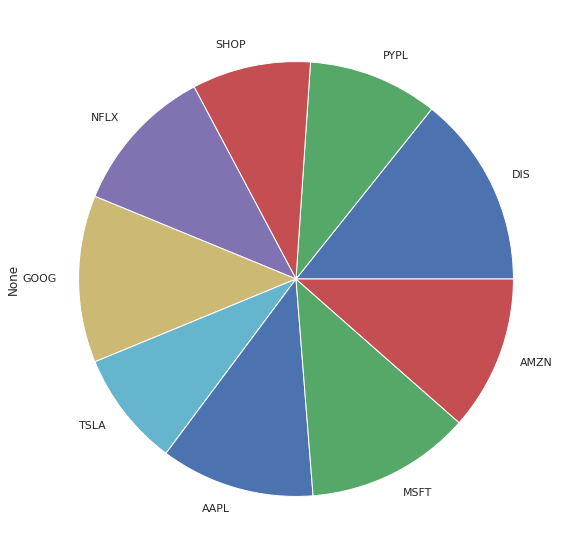

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.min_volatility()
mv_weights = ef.clean_weights()
print(mv_weights)
pd.Series(mv_weights).plot.pie(figsize=(10,10))
# max sharpe allocation

OrderedDict([('DIS', 0.14279), ('PYPL', 0.09657), ('SHOP', 0.08828), ('NFLX', 0.1103), ('GOOG', 0.12422), ('TSLA', 0.08586), ('AAPL', 0.11449), ('MSFT', 0.12257), ('AMZN', 0.11492)])


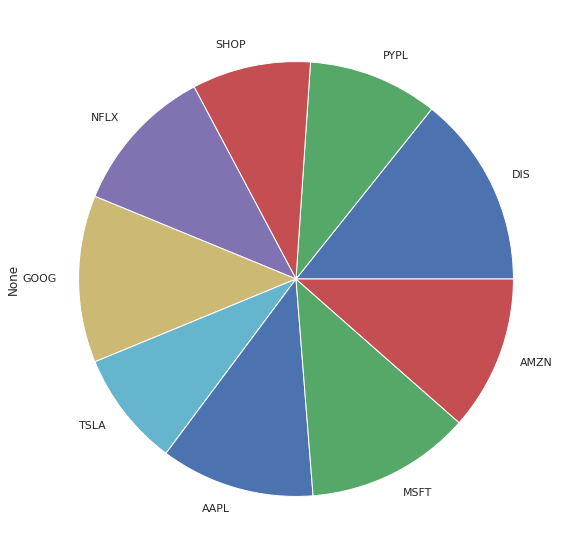

In [ ]:
ef = EfficientFrontier(ret_bl_rf, S_bl_rf)
ef.add_objective(objective_functions.L2_reg)
ef.min_volatility()
mv_rf_weights = ef.clean_weights()
print(mv_rf_weights)
pd.Series(mv_rf_weights).plot.pie(figsize=(10,10))
# max sharpe allocation

OrderedDict([('DIS', 0.02888), ('PYPL', 0.10067), ('SHOP', 0.0), ('NFLX', 0.07336), ('GOOG', 0.12966), ('TSLA', 0.22724), ('AAPL', 0.16633), ('MSFT', 0.12379), ('AMZN', 0.15007)])


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


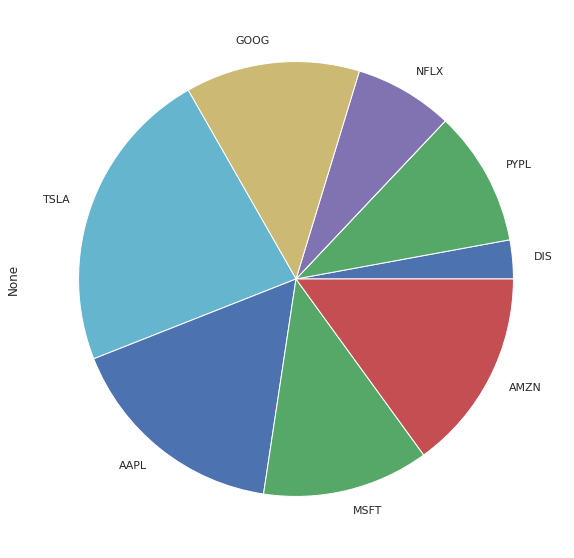

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
ms_weights = ef.clean_weights()
print(ms_weights)
pd.Series(ms_weights).plot.pie(figsize=(10,10))
# max sharpe allocation

OrderedDict([('DIS', 0.02021), ('PYPL', 0.08798), ('SHOP', 0.0628), ('NFLX', 0.04711), ('GOOG', 0.13339), ('TSLA', 0.20259), ('AAPL', 0.18597), ('MSFT', 0.12678), ('AMZN', 0.13317)])


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


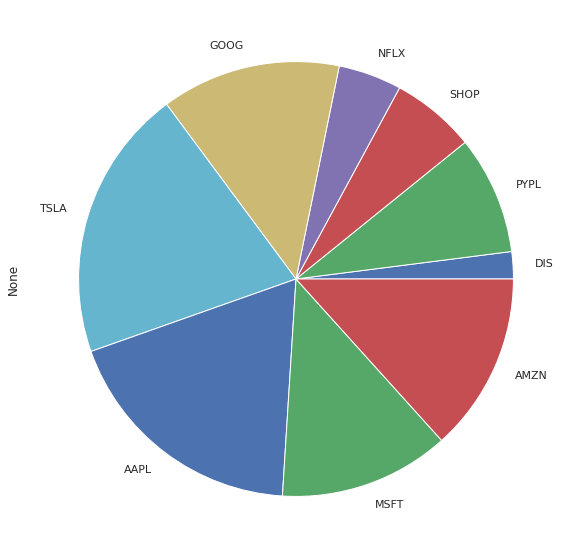

In [ ]:
ef = EfficientFrontier(ret_bl_rf, S_bl_rf)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
ms_rf_weights = ef.clean_weights()
print(ms_rf_weights)
pd.Series(ms_rf_weights).plot.pie(figsize=(10,10))
# max sharpe allocation

In [ ]:
from pypfopt import DiscreteAllocation

Leftover: $12.65


{'AAPL': 113,
 'AMZN': 5,
 'DIS': 16,
 'GOOG': 5,
 'MSFT': 42,
 'NFLX': 13,
 'PYPL': 37,
 'TSLA': 32}

In [ ]:
da = DiscreteAllocation(ms_weights, portfolio.iloc[-1], total_portfolio_value=100000)
alloc_ms, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
# alloc_ms

da = DiscreteAllocation(mv_weights, portfolio.iloc[-1], total_portfolio_value=100000)
alloc_mv, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
# alloc_mv

da = DiscreteAllocation(ms_rf_weights, portfolio.iloc[-1], total_portfolio_value=100000)
alloc_ms_rf, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
# alloc_ms

da = DiscreteAllocation(mv_rf_weights, portfolio.iloc[-1], total_portfolio_value=100000)
alloc_mv_rf, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
# alloc_mv

Leftover: $12.65
Leftover: $36.54
Leftover: $41.17
Leftover: $36.54


In [ ]:
da = DiscreteAllocation(bl_weights, portfolio.iloc[-1], total_portfolio_value=100000)
alloc_bl, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
# alloc_bl

da = DiscreteAllocation(bl_rf_weights, portfolio.iloc[-1], total_portfolio_value=100000)
alloc_bl_rf, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
# alloc_bl_rf

Leftover: $495.13
Leftover: $221.67


In [ ]:
portfolio_pr = pd.concat([v['Close'].iloc[-(test_size):] for v in stock_actual.values()], 1, keys = stock_actual.keys())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
def allocation_return(portfolio_pr, alloc):
  pos_prices = pd.concat([portfolio_pr.iloc[[0,-1]].T, pd.DataFrame(alloc, index = [0]).T], 1)
  pos_prices.columns = ['Price_start','Price_end', 'Allocation']
  pos_prices['Pos_val_start'] = pos_prices['Price_start']*pos_prices['Allocation']
  pos_prices['Pos_val_end'] = pos_prices['Price_end']*pos_prices['Allocation']
  pos_prices['Pos_return'] = (pos_prices['Pos_val_end']-pos_prices['Pos_val_start'])/abs(pos_prices['Pos_val_start'])
  return (pos_prices, (pos_prices['Pos_val_end'].sum()-pos_prices['Pos_val_start'].sum())/pos_prices['Pos_val_start'].sum())

In [ ]:
_, r_ms = allocation_return(portfolio_pr, alloc_ms)
_, r_mv = allocation_return(portfolio_pr, alloc_mv)
_, r_mv_rf = allocation_return(portfolio_pr, alloc_mv_rf)
_, r_ms_rf = allocation_return(portfolio_pr, alloc_ms_rf)

p_pl, r_bl = allocation_return(portfolio_pr, alloc_bl)
p_pl_rf, r_bl_rf = allocation_return(portfolio_pr, alloc_bl_rf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


In [ ]:
print("Min_vol (bl+bilstm/rf) portfolio return", round(r_mv*100, 3), "%\n")

print("Max_sharpe (bl+bilstm) portfolio return", round(r_ms*100, 3), "%\n")
print("Max_sharpe (bl+rf) portfolio return", round(r_ms_rf*100, 3), "%\n")

Min_vol (bl+bilstm/rf) portfolio return 0.301 %

Max_sharpe (bl+bilstm) portfolio return 2.59 %

Max_sharpe (bl+rf) portfolio return 1.543 %



In [ ]:
print("black litterman allocation portfolio return (bilstm prediction)", round(r_bl*100, 3), "%\n")
print("black litterman allocation portfolio return (rf prediction)", round(r_bl_rf*100, 3), "%\n")

black litterman allocation portfolio return (bilstm prediction) 2.289 %

black litterman allocation portfolio return (rf prediction) -2.27 %



In [ ]:
(p_pl['Pos_val_end'] - p_pl['Pos_val_start'])/abs(p_pl['Pos_val_start'])

DIS    -0.023550
PYPL    0.038325
SHOP    0.075254
NFLX   -0.122547
GOOG   -0.026645
TSLA    0.151469
AAPL   -0.035446
MSFT   -0.050039
AMZN    0.030520
dtype: float64

The portfolio had a net positive return over a period of 30 days. However, the low returns can be attributed to the federal reserve tightening rates during the given period to combat inflation resulting from 2 years of quantitative easing during the COVID pandemic.

In [ ]:
p_pl

,Price_start,Price_end,Allocation,Pos_val_start,Pos_val_end,Pos_return
DIS,173.250000,169.169998,4,693.000000,676.679993,-0.023550
PYPL,270.579987,260.209991,-15,-4058.699799,-3903.149872,-0.038325
SHOP,1466.109985,1355.780029,-13,-19059.429810,-17625.140381,-0.075254
NFLX,543.710022,610.340027,-8,-4349.680176,-4882.720215,0.122547
GOOG,2738.270020,2665.310059,6,16429.620117,15991.860352,-0.026645
TSLA,673.469971,775.479980,19,12795.929443,14734.119629,0.151469
AAPL,146.699997,141.500000,149,21858.299545,21083.500000,-0.035446
MSFT,296.769989,281.920013,66,19586.819275,18606.720886,-0.050039
AMZN,3187.750000,3285.040039,9,28689.750000,29565.360352,0.030520
